In [2]:
import pandas as pd

# Load
Get all the clean data and deduplicate, keeping the last row with each ID (which will be the most recently-pulled).

In [25]:
from pathlib import Path
data_files = Path('clean_data').glob('*.json')
df = pd.concat(pd.read_json(filename) for filename in data_files)

In [26]:
df = df.loc[~df.index.duplicated(keep='last')]

In [59]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt

In [60]:
gmap = gpd.read_file('chicago.shp')

In [62]:
from shapely.geometry import Point
points = [Point(y,x) for x, y in zip(df.lat, df.lon)]
gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=points)

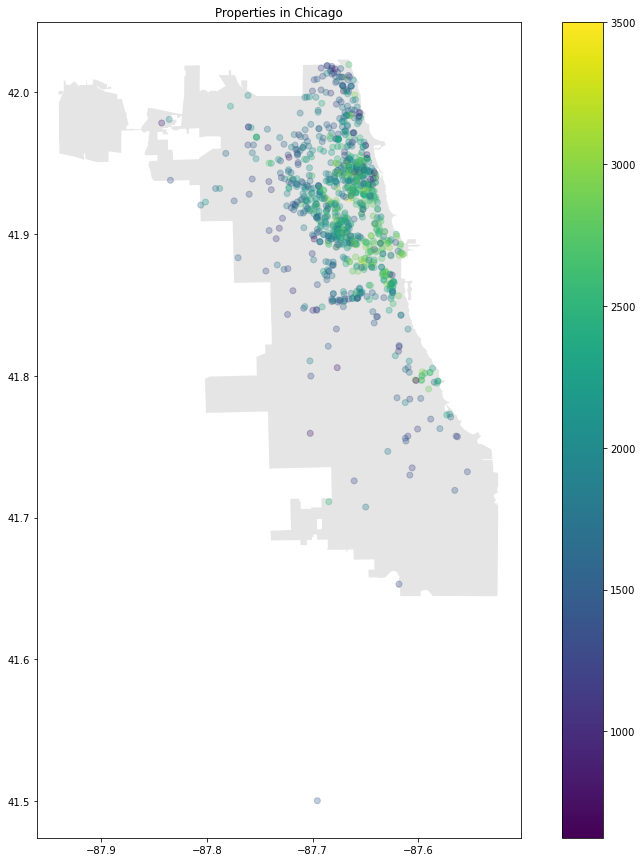

In [70]:
MAP_ALPHA = 0.2
PT_ALPHA = 0.3

fig, ax = plt.subplots(figsize=(15, 15))
gmap.plot(ax=ax, alpha=MAP_ALPHA, color='gray')
gdf.plot(column='price', ax=ax, alpha=PT_ALPHA, marker='o', legend=True)
buildings = gdf[gdf['type'] == 'building']
units = gdf[gdf['type'] == 'unit']
plt.title('Properties in Chicago');
#buildings.plot(column='price', ax=ax, alpha=PT_ALPHA, label='building', marker='x', legend=True)
#units.plot(column='price', ax=ax, alpha=PT_ALPHA, label='unit', marker='o', legend=True)

In [204]:
PRICE_SCORE_WT = 0.3
LOC_SCORE_WT = 0.4
SQFT_SCORE_WT = 0.3
def total_score(row):
    # Take a row representing a property and assign it a score based on how much I'll like it.
    p = PRICE_SCORE_WT * row['price_score']
    l = LOC_SCORE_WT * row['loc_score']
    sq = SQFT_SCORE_WT * row['sqft_score']
    return p + l + sq

In [205]:
def price_score(row):
    # No points for pricing below $1600 -- that's alarming for a 2-bedroom.
    price = row['price'] if row['price'] >= 1600 else 1600
    # Every dollar over $2800 counts double
    penalty = max(price-2800, 0)
    price = price + penalty
    return (4200-price) / 2600

In [206]:
def sqft_score(row):
    sqft = row['sqft']
    if pd.isnull(sqft):
        return 0.2
    if sqft < 500:
        sqft = 500
    elif sqft > 2400:
        sqft = 2400
    acceptability = min(sqft, 1000) / (1000 * 2)
    extra = min(max(1000, sqft), 2400) / (1000 * 4)
    return acceptability + extra

In [207]:
ZIP_SCORES = {
    60601: 0.2, # Abhisek
    60605: 0.1, # South Loop
    60606: 0.1, # OPO proximity
    60607: 0.8, # UIC & Little Italy
    60608: 0.2, # Pilsen and West Bridgeport
    60610: 0.7, # Gold Coast, Cabrini Green
    60611: 0.1, # Streeterville
    60614: 0.7, # South Lincoln Park
    60613: 0.3, # Wrigleyville and North
    60622: 0.4, # Ukrainian Village, Humboldt Park, some Wicker Park
    60642: 0.6, # Noble Square & Goose Island
    60647: 0.3, # Logan Square and Wicker Park
    60654: 0.1, # River North
    60657: 0.5, # Lakeview
    60661: 0.3, # Greektown
    
}
def loc_score(row):
    if pd.notnull(row['zipcode']):
        if row['zipcode'] in ZIP_SCORES:
            zip_score = ZIP_SCORES[row['zipcode']]
        else:
            rogues.append(row['zipcode'])
            zip_score = 0
    else:
        zip_score = 0.3
    # Bonus points for being within a 0.5 miles of my preferred location
    if row['old_town_distance'] <= 1:
        pref_pt_score = (1 - (row['old_town_distance'] ** 2)) / 4
    else:
        pref_pt_score = 0
    return zip_score + pref_pt_score

In [208]:
df['loc_score'] = df.apply(loc_score, axis=1)
df['sqft_score'] = df.apply(sqft_score, axis=1)
df['price_score'] = df.apply(price_score, axis=1)
df['total_score'] = df.apply(total_score, axis=1)

Most promising properties...

In [209]:
promising = df.sort_values('total_score', ascending=False)
promising.head()

,price,address,lat,lon,zipcode,url,days_on_zillow,beds,baths,sqft,type,old_town_distance,geometry,loc_score,sqft_score,price_score,total_score
zpid_2102990066,1750,"1612 N Sedgwick St APT 2F, Chicago, IL 60614",41.911496,-87.638948,60614.0,https://www.zillow.com/homedetails/1612-N-Sedg...,0,2.0,1.0,1000.0,unit,0.358998,POINT (-87.63895 41.91150),0.917780,0.750,0.942308,0.874804
zpid_2092425346,1945,"1628 N Wells St #2, Chicago, IL 60614",41.912048,-87.635287,60614.0,https://www.zillow.com/homedetails/1628-N-Well...,1,2.0,1.0,1100.0,unit,0.200277,POINT (-87.63529 41.91205),0.939972,0.775,0.867308,0.868681
zpid_2113176683,1775,"2450 N Southport Ave #1, Chicago, IL 60614",41.926742,-87.663701,60614.0,https://www.zillow.com/homedetails/2450-N-Sout...,0,2.0,1.0,1280.0,unit,1.981649,POINT (-87.66370 41.92674),0.700000,0.820,0.932692,0.805808
zpid_2112903578,1795,"2758 N Ashland Ave APT 2F, Chicago, IL 60614",41.932283,-87.668743,60614.0,https://www.zillow.com/homedetails/2758-N-Ashl...,0,2.0,1.0,1300.0,unit,2.419128,POINT (-87.66874 41.93228),0.700000,0.825,0.925000,0.805000
zpid_2072152146,1890,"869 N Lasalle St #2, Chicago, IL 60610",41.898149,-87.632834,60610.0,https://www.zillow.com/homedetails/869-N-Lasal...,0,2.0,1.0,1000.0,unit,0.840849,POINT (-87.63283 41.89815),0.773243,0.750,0.888462,0.800836


In [228]:
from IPython.display import HTML

h = []
for i, (_, row) in enumerate(promising.iloc[:100].iterrows(), 1):
    h.append(f'{i}. <a href="{row.url}">{row.address}</a> '
             f'-- ${row.price}, {row.beds} beds, {row.baths} baths, {row.sqft} sqft '
             f'--  Total score: <b>{row.total_score:.3f}</b>')
html = '<br>'.join(h)
HTML(html)

In [202]:
for i, url in enumerate(promising.head(100).url, 1):
    print(f'{i}. {url}')

1. https://www.zillow.com/homedetails/1612-N-Sedgwick-St-APT-2F-Chicago-IL-60614/2102990066_zpid/
2. https://www.zillow.com/homedetails/1628-N-Wells-St-2-Chicago-IL-60614/2092425346_zpid/
3. https://www.zillow.com/homedetails/1944-N-Bissell-St-G-Chicago-IL-60614/2087725855_zpid/
4. https://www.zillow.com/homedetails/869-N-Lasalle-St-2-Chicago-IL-60610/2072152146_zpid/
5. https://www.zillow.com/homedetails/2450-N-Southport-Ave-1-Chicago-IL-60614/2113176683_zpid/
6. https://www.zillow.com/homedetails/2758-N-Ashland-Ave-APT-2F-Chicago-IL-60614/2112903578_zpid/
7. https://www.zillow.com/homedetails/2422-N-Ashland-Ave-APT-2R-Chicago-IL-60614/2124744638_zpid/
8. https://www.zillow.com/homedetails/700-W-Van-Buren-St-APT-1305-Chicago-IL-60607/61962948_zpid/
9. https://www.zillow.com/homedetails/1445-N-Wieland-St-4TD0J31S1-Chicago-IL-60610/2071913361_zpid/
10. https://www.zillow.com/homedetails/437-W-Division-St-APT-815-Chicago-IL-60610/101281226_zpid/
11. https://www.zillow.com/homedetails/245

<AxesSubplot:>

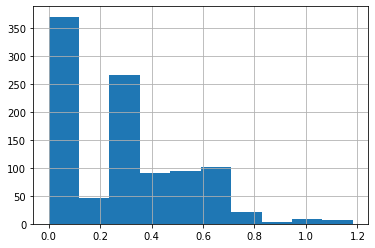

In [193]:
df.loc_score.hist()

<AxesSubplot:>

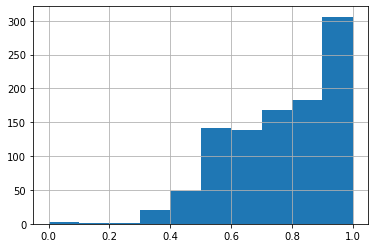

In [180]:
df.price_score.hist()

<AxesSubplot:>

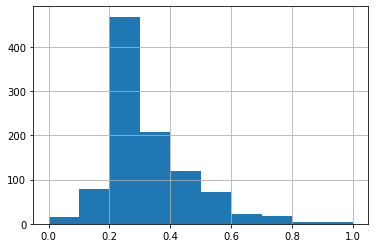

In [124]:
df.sqft_score.hist()